## Setting Up Environment

*Ran using bash

In [1]:
!nvidia-smi

Sun Oct 13 10:45:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8     4W /  N/A |      9MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# To ensure python 3.12 is used (anything over 3.10 is fine in order for SAM2 to run)
# Creates a `myenv`` virtual environment (as shown in the folder)
# Sample code for windows:
# !py -3.12 -m venv myenv
# !myenv\Scripts\activate
# !python
!python --version

Python 3.12.7


In [5]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: C:\Users\RC\Downloads\BCNN_project


In [7]:
# Installing SAM2 (Reference: https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb#scrollTo=nx8UNmABNkJP)

!pip install pickleshare

# Clone and install SAM2 from Meta's repository
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

C:\Users\RC\Downloads\BCNN_project\segment-anything-2


fatal: destination path 'segment-anything-2' already exists and is not an empty directory.


In [8]:
!pip install -q supervision jupyter_bbox_widget

**NOTE**: SAM2 is available in 4 different model sizes, as imported below

In [9]:
!pip install wget
import wget

  Using cached wget-3.2.zip (10 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=f17e6eaf8129154082ad8e5d42d605c13af7540a9250ac127079bdb88cd14a65
  Stored in directory: c:\users\rc\appdata\local\pip\cache\wheels\01\46\3b\e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [11]:
# !mkdir -p {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints


# Same implementation as the code above
os.makedirs(os.path.expanduser('~/checkpoints'), exist_ok=True)

# Define the URLs and destination paths
urls = [
    "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt",
    "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt",
    "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt",
    "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"
]

# Download each file
for url in urls:
    filename = os.path.join(os.path.expanduser('~/checkpoints'), os.path.basename(url))
    wget.download(url, filename)

100% [......................................................................] 897952466 / 897952466

Getting some images for testing

### Importing

In [29]:
!pip install numpy matplotlib pillow scikit-learn
!pip install opencv-python
!pip install supervision
!pip install torch==2.3.1+cu118 torchvision==0.18.1+cu118 torchaudio==2.2.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 58.6 MB/s eta 0:00:46
     ---------------------------------------- 0.0/2.7 GB 51.7 MB/s eta 0:00:52
     ---------------------------------------- 0.0/2.7 GB 53.8 MB/s eta 0:00:50
      --------------------------------------- 0.0/2.7 GB 56.3 MB/s eta 0:00:47
      --------------------------------------- 0.0/2.7 GB 49.0 MB/s eta 0:00:54
      --------------------------------------- 0.1/2.7 GB 52.1 MB/s eta 0:00:51
     - -------------------------------------- 0.1/2.7 GB 52.6 MB/s eta 0:00:50
     - -------------------------------------- 0.1/2.7 GB 54.4 MB/s eta 0:00:48
     - -------------------------------------- 0.1/2.7 GB 52.3 MB/s eta 0:00:50
     - -------------------------------------- 0.1/2.7 GB 50.7 MB/s eta 0:00:51
     - -------------------------------------- 0.1/2.7 GB 51.2 MB/s eta

ERROR: Cannot install torch==2.3.1+cu118, torchaudio==2.2.2+cu118 and torchvision==0.18.1+cu118 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [13]:
# Importing Necessary Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random
import cv2
import base64
import supervision as sv

# Importing SAM2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# # Pre-trained Bayesian CNN model for uncertainty estimation
# # Can be fine-tuned with medical data
# from bnn_pytorch import BayesianCNN

# # Dataset Links
# CHEST_XRAY_DATASET_URL = "https://paperswithcode.com/dataset/chestx-ray14"
# BRAIN_MRI_DATASET_URL = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10584795/"

# For Bayesian layers
from torch.nn.functional import dropout
from torch.distributions import Normal

**NOTE:** This code enables mixed-precision computing for faster deep learning  (bfloat16 and TensorFloat-32 (TF32)).

In [28]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

AssertionError: Torch not compiled with CUDA enabled

## Loading in a SAM2 model
**Note**: Can choose between the 4 models

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt" # Choosing the large model
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

Tuneable parameters for advanced mask generation:
- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [13]:
IMAGE_PATH = f"{HOME}/extracted_images/test/00007046_012.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Output format example

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [17]:
sam2_result = mask_generator.generate(image_rgb)

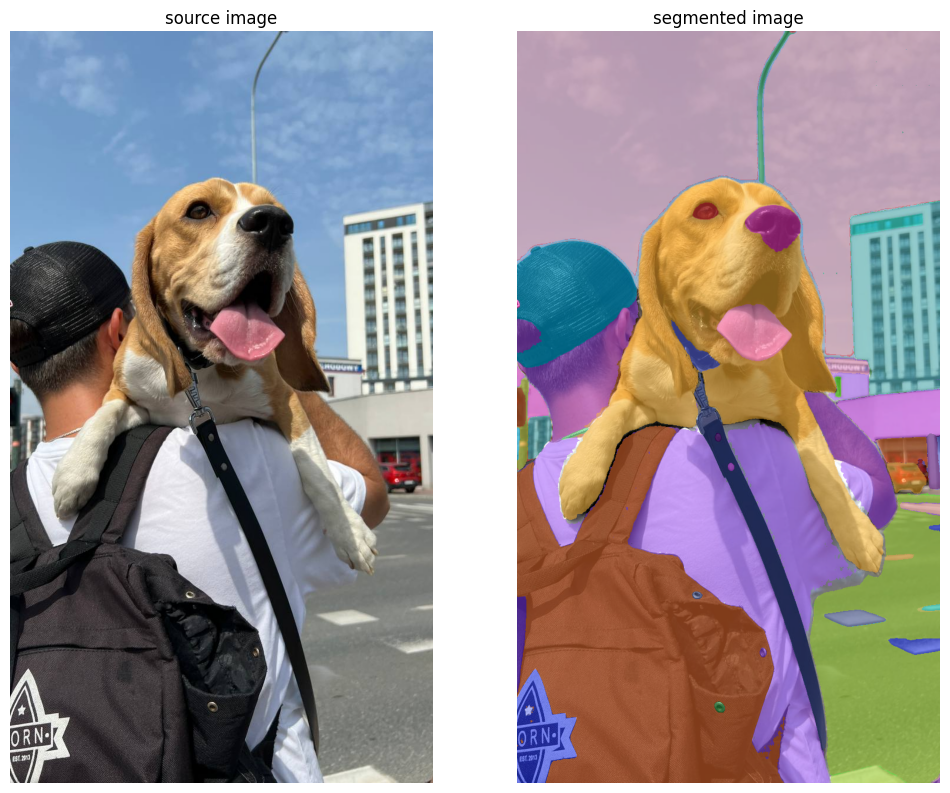

In [16]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Getting Started with the Medical Dataset

In [ ]:
# Data Preprocessing
class MedicalImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Dataset
def load_data():
    # Assuming data is already downloaded
    train_data = MedicalImageDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
    val_data = MedicalImageDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_data()

# Model Implementation
class BCNN_Model(nn.Module):
    def __init__(self):
        super(BCNN_Model, self).__init__()
        # Using DenseNet as the CNN backbone
        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()

        # Bayesian layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 2)  # Binary classification (Disease vs No Disease)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Uncertainty Estimation using Monte Carlo Dropout
def mc_dropout(model, images, n_samples=100):
    model.train()  # Enable dropout at inference
    preds = [model(images) for _ in range(n_samples)]
    return torch.stack(preds).mean(0), torch.stack(preds).std(0)

# Training Loop
def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    return model

# Evaluation Metrics
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            preds = model(inputs)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

# Initialize and train the model
model = BCNN_Model()
trained_model = train_model(model, train_loader, val_loader)

# Evaluate the trained model
evaluate_model(trained_model, val_loader)

# Uncertainty Estimation on test data
images, _ = next(iter(val_loader))
mean_preds, uncertainty = mc_dropout(trained_model, images)
print(f"Mean predictions: {mean_preds}, Uncertainty: {uncertainty}")

Citations:
```
@inproceedings{Wang_2017,
	doi = {10.1109/cvpr.2017.369},
	url = {https://doi.org/10.1109%2Fcvpr.2017.369},
	year = 2017,
	month = {jul},
	publisher = {{IEEE}
},
	author = {Xiaosong Wang and Yifan Peng and Le Lu and Zhiyong Lu and Mohammadhadi Bagheri and Ronald M. Summers},
	title = {{ChestX}-Ray8: Hospital-Scale Chest X-Ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases},
	booktitle = {2017 {IEEE} Conference on Computer Vision and Pattern Recognition ({CVPR})}
}
```